<img align="right" src="https://zenodo.org/record/7742997/files/Tops_Badge_Nasa.png" width="180" alt="NASA TOPS Logo">

# **Mapping Wildfire Burned Areas Using VIIRS/AVIRIS-3 Data (Python)**

Author [David Fonseca](https://www.linkedin.com/in/david-fonseca2/)

In this lesson, you will learn to access, preprocess, and analyze AVIRIS-3 data to map burned areas from the Palisades Fire in Los Angeles. Using satellite imagery obtained through the VIIRS tool, you will examine pre- and post-fire conditions, assess the fire’s impact on vegetation and infrastructure.



### Learning Objectives
By the end of this lesson, you should be able to:
- **Access and download AVIRIS-3** and **VIIRS Burn Area data** for wildfire analysis.
- **Preprocess and clean AVIRIS-3 spectral radiance data** for visualization.
- **Compare pre- and post-fire imagery** to assess vegetation and burned area changes.
- **Overlay VIIRS Burn Area data** with **AVIRIS-3 images** using **GIS tools** to map burned areas.
- **Evaluate wildfire impact** by analyzing the overlap of burn data with **infrastructure** (e.g., buildings, population, critical infrastructure).
- **Quantify damage** and **assess risk** to urban zones and infrastructure.

### Introduction
Wildfires are one of the most devastating natural disasters, affecting ecosystems, wildlife, and human settlements. The Palisades Fire, which ignited on January 6, 2025, in the Los Angeles area, is a recent example of a wildfire that spread rapidly, impacting both natural environments and urban infrastructure. In this lesson, we will use AVIRIS-3 satellite imagery, accessed via the VIIRS tool, and VIIRS burn area data to analyze the fire’s effects.

By comparing pre-fire and post-fire imagery, we will evaluate how vegetation changed and overlay this information with infrastructure data to assess the damage. This exercise will help you understand how remote sensing can support wildfire monitoring and risk analysis.

#### Palisades Fire Overview
The Palisades Fire affected large parts of the Los Angeles region, particularly residential areas and natural vegetation. Satellite imagery from AVIRIS-3 and VIIRS provides us with valuable data to assess the extent of the fire's impact. By overlaying burn area data with infrastructure maps, we can determine how much of the urban and natural landscapes were affected. The data allows us to quantify the impact and identify areas at high risk.

## 1. Accessing Wildfire Data
### Understanding AVIRIS-3 Data
AVIRIS-3 provides high-resolution hyperspectral imagery across a wide range of wavelengths, allowing for detailed analysis of land surface properties.

In [1]:
import os
import earthaccess
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import griddata

# Authenticate with NASA Earthdata (you need an account)
Auth = earthaccess.login()

Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}


LoginAttemptFailure: Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}

In [2]:
# Search for VIIRS Burned Area data
viirs_data = earthaccess.search_data(
    short_name="AV3_L1B_RDN_2356", 
    temporal=('2025-01-16', '2025-01-16'),  # Palisades's wildfire (January 6 - January 17 2025)
    bounding_box=(-118.8, 33.9, -118.46, 34.28)  # Bounding box for Palisades California
)

print(f"Found {len(viirs_data)} files.")

Found 31 files.


## 2. Processing and Visualizing Satellite Images

In [7]:
# Extract OBS.NC and TIFF file URLs from VIIRS data
granulate_urls = [
    [file_url for file_url in file.data_links() if file_url.endswith('RDN.nc')]
    for file in viirs_data[-6:]
]

# Directory to save downloaded files
download_dir = '../data/granulate_files'

# Ensure the download directory exists
os.makedirs(download_dir, exist_ok=True)

for granulate in granulate_urls:
    # Download files
    earthaccess.download(granulate, download_dir)
            
print("Processing complete for all granulates.")

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 393.87it/s]
PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | : 100%|██████████| 1/1 [01:37<00:00, 97.94s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 372.66it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:35<00:00, 95.03s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9198.04it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 501.71it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:35<00:00, 95.03s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7584.64it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 290.36it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:34<00:00, 94.05s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6533.18it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 577.25it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1952.66it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7503.23it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:

Processing complete for all granulates.


C:\Users\daysi\AppData\Local\Temp\ipykernel_33896\1638656401.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')


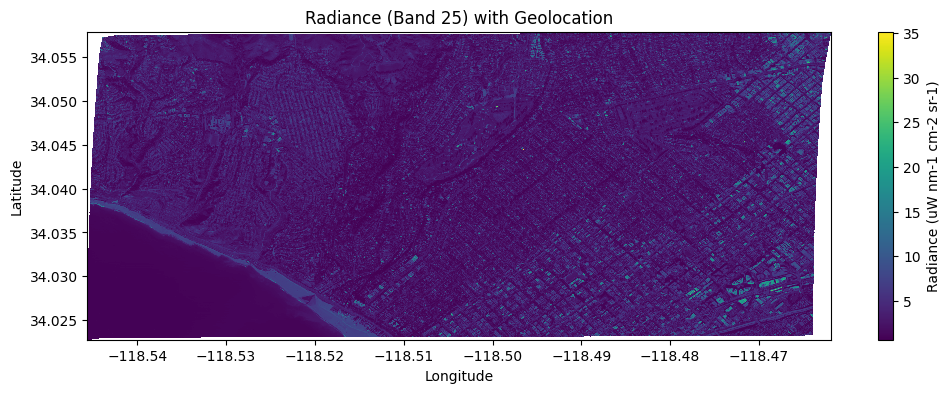

In [13]:
file_path = "../data/granulate_files/AV320250116t193840_005_L1B_RDN_3f4aef90_RDN.nc"

# Open the file and plot radiance with geolocation
with h5py.File(file_path, 'r') as f:
    radiance = f['radiance']['radiance']
    lat = f['lat'][:]
    lon = f['lon'][:]
    
    # Take a specific band (like band 25)
    data = radiance[25, :, :]
    
    # Create cell edges
    lon_edges = (lon[:-1, :-1] + lon[1:, 1:]) / 2
    lat_edges = (lat[:-1, :-1] + lat[1:, 1:]) / 2
    
    # Sort to fix the monotonic issue
    lon_edges = np.sort(lon_edges, axis=1)
    lat_edges = np.sort(lat_edges, axis=0)

    plt.figure(figsize=(12, 4))
    plt.pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')
    plt.colorbar(label='Radiance (uW nm-1 cm-2 sr-1)')
    plt.title('Radiance (Band 25) with Geolocation')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

C:\Users\daysi\AppData\Local\Temp\ipykernel_33896\1005354881.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon_edges, lat_edges, nbr[:-1, :-1], shading='auto', cmap='RdYlBu_r', vmin=-1, vmax=1)


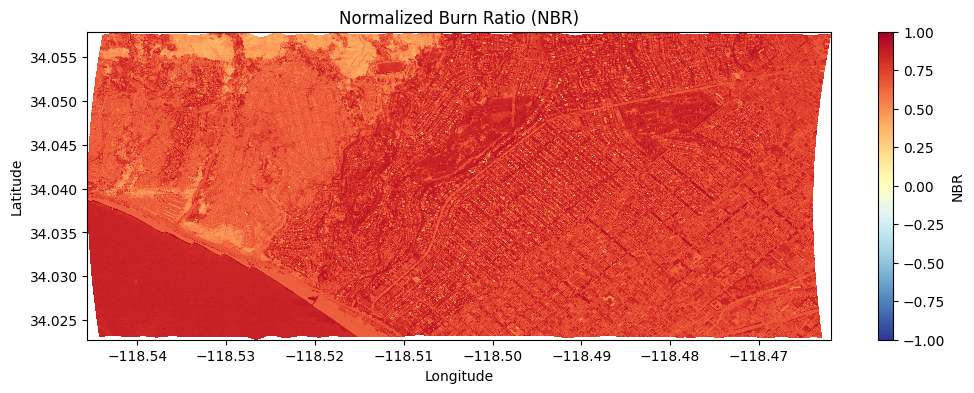

In [11]:
# Open the file and compute NBR
with h5py.File(file_path, 'r') as f:
    radiance = f['radiance']['radiance']
    lat = f['lat'][:]
    lon = f['lon'][:]

    # Choose the NIR and SWIR bands (based on wavelength list)
    nir_band = radiance[63, :, :]  # ~858.6 nm
    swir_band = radiance[181, :, :]  # ~2205.2 nm
    
    # Compute NBR
    nbr = (nir_band - swir_band) / (nir_band + swir_band)
    
    # Mask out invalid values
    nbr = np.ma.masked_invalid(nbr)
    
    # Clip NBR values to between -1 and 1
    nbr = np.clip(nbr, -1, 1)

    # Create cell edges for proper alignment
    lon_edges = (lon[:-1, :-1] + lon[1:, 1:]) / 2
    lat_edges = (lat[:-1, :-1] + lat[1:, 1:]) / 2

    # Plot NBR with better color contrast
    plt.figure(figsize=(12, 4))
    plt.pcolormesh(lon_edges, lat_edges, nbr[:-1, :-1], shading='auto', cmap='RdYlBu_r', vmin=-1, vmax=1)
    plt.colorbar(label='NBR')
    plt.title('Normalized Burn Ratio (NBR)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

C:\Users\daysi\AppData\Local\Temp\ipykernel_24700\2344747754.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = axes[i].pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')


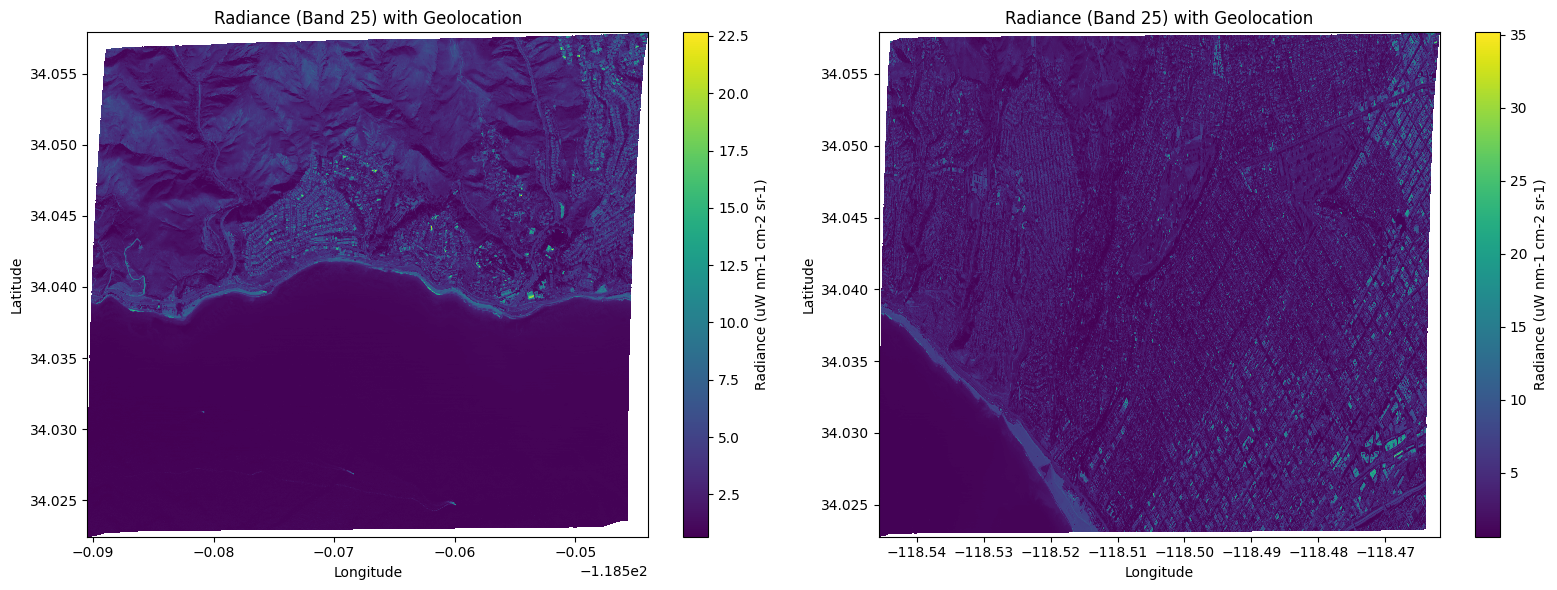

In [21]:
granule_paths = glob.glob('../data/*/*RDN.nc')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

for i, path in enumerate(granule_paths[:2]):
    # Open the file and plot radiance with geolocation
    with h5py.File(path, 'r') as f:
        radiance = f['radiance']['radiance']
        lat = f['lat'][:]
        lon = f['lon'][:]
        
        # Take a specific band (like band 25)
        data = radiance[25, :, :]
        
        # Create cell edges
        lon_edges = (lon[:-1, :-1] + lon[1:, 1:]) / 2
        lat_edges = (lat[:-1, :-1] + lat[1:, 1:]) / 2
        
        # Sort to fix the monotonic issue
        lon_edges = np.sort(lon_edges, axis=1)
        lat_edges = np.sort(lat_edges, axis=0)

        pcm = axes[i].pcolormesh(lon_edges, lat_edges, data[:-1, :-1], shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=axes[i], label='Radiance (uW nm-1 cm-2 sr-1)')
        axes[i].set_title('Radiance (Band 25) with Geolocation')
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
plt.tight_layout()
plt.show()

C:\Users\daysi\AppData\Local\Temp\ipykernel_24700\2463504145.py:47: RuntimeWarning: Mean of empty slice
  merged_radiance = np.nanmean(np.array([merged_radiance_1, merged_radiance_2]), axis=0)


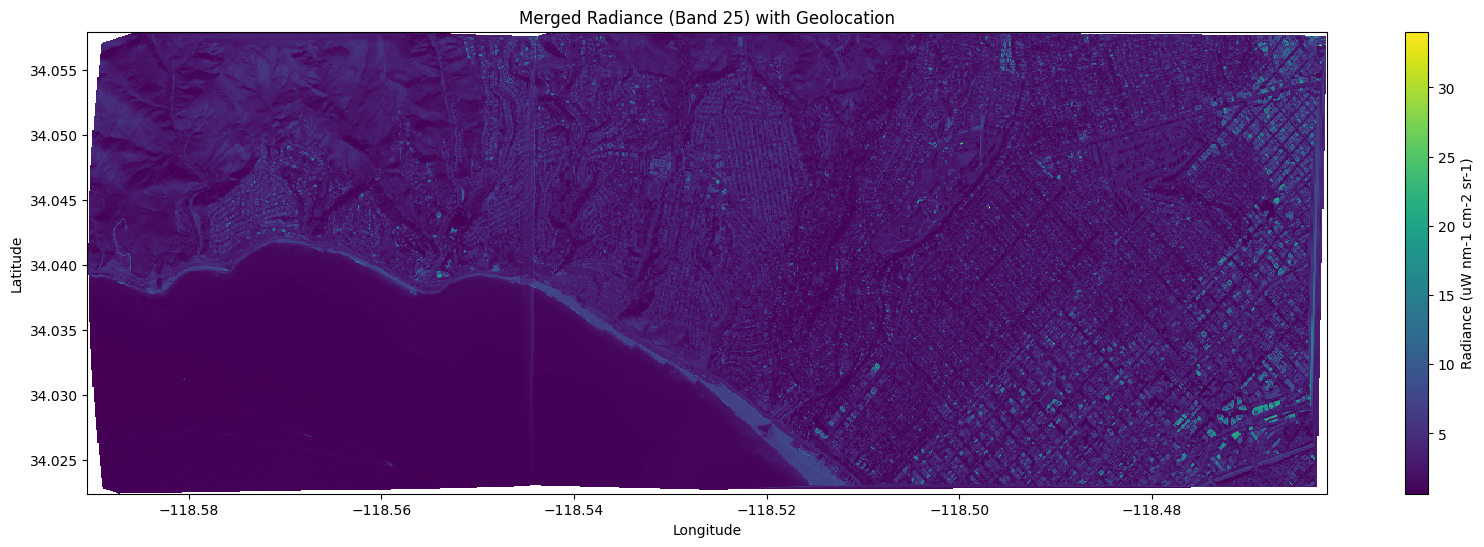

In [ ]:
# Paths to the granules
file_path_1 = "../data/granulate_files/AV320250116t193840_004_L1B_RDN_3f4aef90_RDN.nc"
file_path_2 = "../data/granulate_files/AV320250116t193840_005_L1B_RDN_3f4aef90_RDN.nc"

# Open the files and read data
with h5py.File(file_path_1, 'r') as f1, h5py.File(file_path_2, 'r') as f2:
    # Radiance data
    radiance_1 = f1['radiance']['radiance'][25, :, :]
    radiance_2 = f2['radiance']['radiance'][25, :, :]

    # Latitude and longitude data
    lat_1 = f1['lat'][:]
    lon_1 = f1['lon'][:]
    lat_2 = f2['lat'][:]
    lon_2 = f2['lon'][:]

    # Flatten the arrays for interpolation
    points_1 = np.array([lon_1.flatten(), lat_1.flatten()]).T
    points_2 = np.array([lon_2.flatten(), lat_2.flatten()]).T

    # Combine radiance and geolocation data
    radiance_1_flat = radiance_1.flatten()
    radiance_2_flat = radiance_2.flatten()

    # Define a common grid based on the min/max lat/lon
    lon_min = min(lon_1.min(), lon_2.min())
    lon_max = max(lon_1.max(), lon_2.max())
    lat_min = min(lat_1.min(), lat_2.min())
    lat_max = max(lat_1.max(), lat_2.max())

    # Define resolution for the grid
    num_points = 1000
    grid_lon = np.linspace(lon_min, lon_max, num_points)
    grid_lat = np.linspace(lat_min, lat_max, num_points)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Interpolate both granules to the common grid
    merged_radiance_1 = griddata(points_1, radiance_1_flat, (grid_lon, grid_lat), method='linear')
    merged_radiance_2 = griddata(points_2, radiance_2_flat, (grid_lon, grid_lat), method='linear')

    # Merge the two granules by averaging overlapping regions
    merged_radiance = np.nanmean(np.array([merged_radiance_1, merged_radiance_2]), axis=0)

# Plot the merged granules
plt.figure(figsize=(20, 6))
plt.pcolormesh(grid_lon, grid_lat, merged_radiance, shading='auto', cmap='viridis')
plt.colorbar(label='Radiance (uW nm-1 cm-2 sr-1)')
plt.title('Merged Radiance (Band 25) with Geolocation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


C:\Users\daysi\AppData\Local\Temp\ipykernel_33896\1980464006.py:52: RuntimeWarning: Mean of empty slice
  merged_radiance = np.nanmean(merged_radiance_list, axis=0)


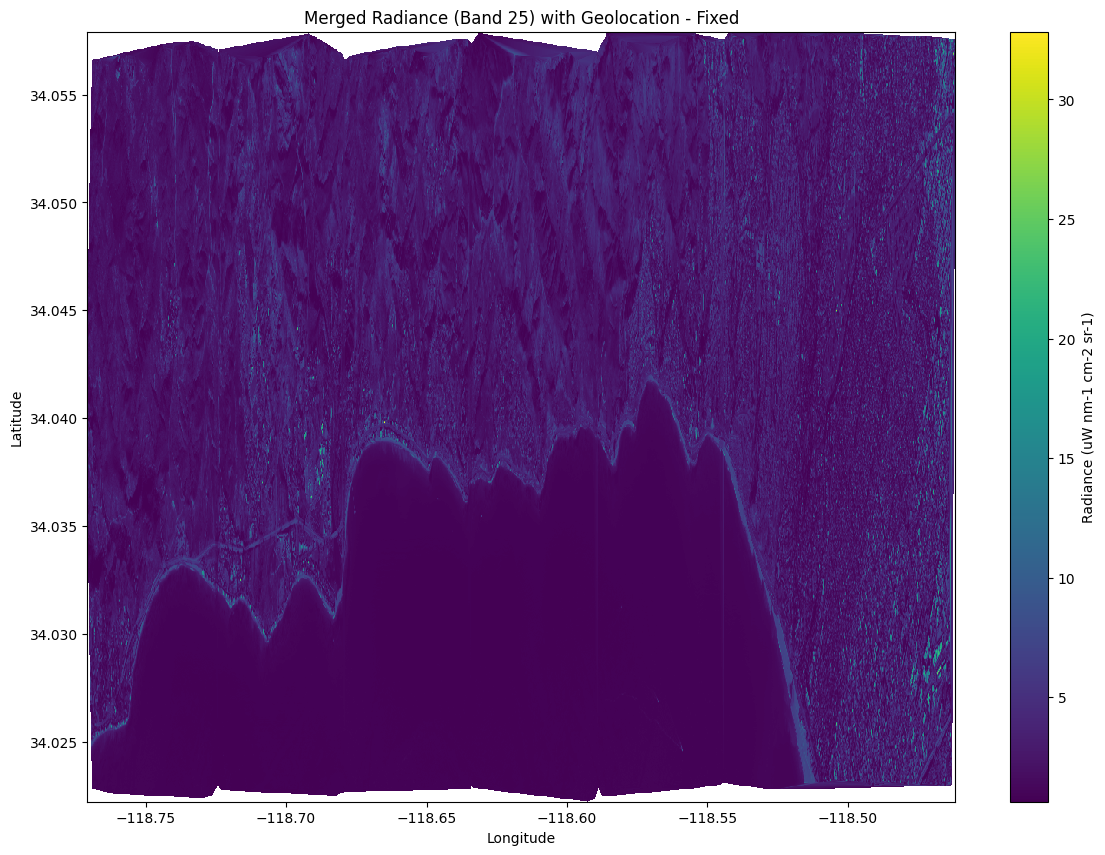

In [26]:
# List of file paths (ordered west to east)
file_paths = sorted(glob.glob('../data/*/*RDN.nc'))

# Band to extract
band = 25

# Define resolution for the common grid
num_points = 1000

# Initialize common grid bounds
lon_min, lon_max = float('inf'), float('-inf')
lat_min, lat_max = float('inf'), float('-inf')

# First loop to define grid bounds
for file_path in file_paths:
    with h5py.File(file_path, 'r') as f:
        lat = f['lat'][:]
        lon = f['lon'][:]
        lon_min = min(lon_min, lon.min())
        lon_max = max(lon_max, lon.max())
        lat_min = min(lat_min, lat.min())
        lat_max = max(lat_max, lat.max())

# Create common grid
grid_lon = np.linspace(lon_min, lon_max, num_points)
grid_lat = np.linspace(lat_min, lat_max, num_points)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Initialize container for merged data
merged_radiance_list = []

# Second loop to process each granule and interpolate to the grid
for file_path in file_paths:
    with h5py.File(file_path, 'r') as f:
        radiance = f['radiance']['radiance'][band, :, :]
        lat = f['lat'][:]
        lon = f['lon'][:]
        
        # Flatten arrays for interpolation
        points = np.array([lon.flatten(), lat.flatten()]).T
        radiance_flat = radiance.flatten()
        
        # Interpolate to common grid
        interpolated_radiance = griddata(
            points, radiance_flat, (grid_lon, grid_lat), method='linear'
        )
        
        # Store result for averaging
        merged_radiance_list.append(interpolated_radiance)

# Average the overlapping areas across all granules
merged_radiance = np.nanmean(merged_radiance_list, axis=0)

# ✅ Plot the merged result
plt.figure(figsize=(14, 10))
plt.pcolormesh(grid_lon, grid_lat, merged_radiance, shading='auto', cmap='viridis')
plt.colorbar(label='Radiance (uW nm-1 cm-2 sr-1)')
plt.title(f'Merged Radiance (Band {band}) with Geolocation - Fixed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

--> 2. ../data\granulate_files\AV320250116t193840_000_L1B_RDN_3f4aef90_RDN.nc processing...
--> 2. ../data\granulate_files\AV320250116t193840_001_L1B_RDN_3f4aef90_RDN.nc processing...
--> 2. ../data\granulate_files\AV320250116t193840_002_L1B_RDN_3f4aef90_RDN.nc processing...
--> 2. ../data\granulate_files\AV320250116t193840_003_L1B_RDN_3f4aef90_RDN.nc processing...
--> 2. ../data\granulate_files\AV320250116t193840_004_L1B_RDN_3f4aef90_RDN.nc processing...
--> 2. ../data\granulate_files\AV320250116t193840_005_L1B_RDN_3f4aef90_RDN.nc processing...


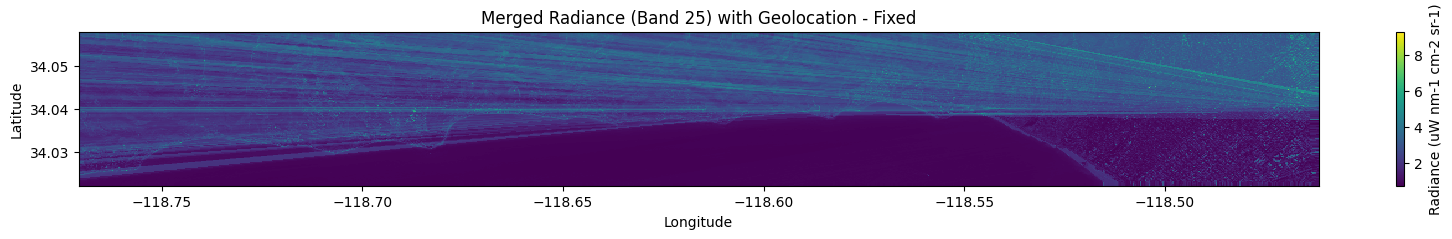

In [2]:
# List of file paths (ordered west to east)
file_paths = sorted(glob.glob('../data/*/*RDN.nc'))

# Band to extract
band = 25

# Define resolution for the common grid
num_points = 1000

# Initialize common grid bounds
lon_min, lon_max = float('inf'), float('-inf')
lat_min, lat_max = float('inf'), float('-inf')

# First loop to define grid bounds
for file_path in file_paths:
    with h5py.File(file_path, 'r') as f:
        lat = f['lat'][:]
        lon = f['lon'][:]
        lon_min = min(lon_min, lon.min())
        lon_max = max(lon_max, lon.max())
        lat_min = min(lat_min, lat.min())
        lat_max = max(lat_max, lat.max())

# Create common grid
grid_lon = np.linspace(lon_min, lon_max, num_points)
grid_lat = np.linspace(lat_min, lat_max, num_points)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Initialize container for merged data
merged_radiance_list = []

# Second loop to process each granule and interpolate to the grid
for file_path in file_paths:
    print(f'--> 2. {file_path} processing...')
    with h5py.File(file_path, 'r') as f:
        radiance = f['radiance']['radiance'][band, :, :]
        lat = f['lat'][:]
        lon = f['lon'][:]
        
        # Flatten arrays for interpolation
        points = np.array([lon.flatten(), lat.flatten()]).T
        radiance_flat = radiance.flatten()
        
        # Interpolate to common grid
        interpolated_radiance = griddata(
            points, radiance_flat, (grid_lon, grid_lat), method='nearest'
        )
        
        # Store result for averaging
        merged_radiance_list.append(interpolated_radiance)

# Average the overlapping areas across all granules
merged_radiance = np.nanmean(merged_radiance_list, axis=0)

# ✅ Plot the merged result
plt.figure(figsize=(20, 2))
plt.pcolormesh(grid_lon, grid_lat, merged_radiance, shading='auto', cmap='viridis')
plt.colorbar(label='Radiance (uW nm-1 cm-2 sr-1)')
plt.title(f'Merged Radiance (Band {band}) with Geolocation - Fixed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 3. Mapping Burned Areas

In [ ]:
import folium

# Create a map centered at a specific latitude and longitude
m = folium.Map(location=[34.083608, -118.634679], zoom_start=12)

# Add a marker
folium.Marker([34.083608, -118.634679], popup="San Francisco").add_to(m)

# Display the map
m

## 4. Assessing Impact

## 5. Conclusion